# MuhRec in python demonstration

In [21]:
import sys, os
sys.path.insert(0, "/Users/kaestner/git/imagingsuite/frameworks/install/lib")
sys.path.insert(0, "/Users/kaestner/git/scripts/python/")
if 'LD_LIBRARY_PATH' not in os.environ:
    os.environ['LD_LIBRARY_PATH'] = '/Users/kaestner/git/imagingsuite/frameworks/install/lib'
    os.execv(sys.argv[0], sys.argv)

if 'DYLD_LIBRARY_PATH' not in os.environ:
    os.environ['DYLD_LIBRARY_PATH'] = '/Users/kaestner/git/imagingsuite/frameworks/install/lib'
    os.execv(sys.argv[0], sys.argv)



PermissionError: [Errno 13] Permission denied

In [34]:
import numpy as np
import muhrectomo as mt
import matplotlib.pyplot as plt
import amglib.readers as io
import amglib.imageutils as amg

In [43]:
import importlib
importlib.reload(mt)
importlib.reload(io)

<module 'amglib.readers' from '/Users/kaestner/git/scripts/python/amglib/readers.py'>

## Create a reconstructor object

In [26]:
recon = mt.Reconstructor(mt.bpMultiProj)

print("Created reconstructor :",recon.name())

Created reconstructor : Multi projection BP


## Reconstruction workflow

### Numerical dummy
This dummy is only to test the connection and that the reconstructor starts at all. Only nonsense data.

In [27]:
Nproj = 10
proj = np.ones([Nproj,256,256])

In [28]:
args = {"angles" : np.linspace(0,180,num=Nproj), 
        "weights" : np.ones(Nproj)}

In [29]:
recon.configure({   "center" : 50, 
                    "resolution" : 0.135
                })

In [30]:
recon.process(proj,args)

vol = recon.volume()

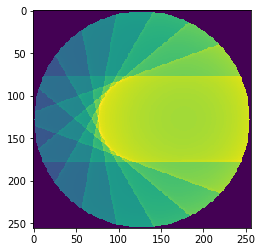

In [31]:
plt.imshow(vol[0])

### The wood data
The wood data is the data I use a lot for demos, tests, and tutorials. It a piece of petrified wood [DOI](http://dx.doi.org/10.17632/g5snr785xy.2). 

#### Load projection data

In [39]:
ob = io.readImages('/data/P08062_wood/raw_CCD/ob_{0:04d}.fits',1,5,averageStack=True).mean(axis=0)
dc = io.readImages('/data/P08062_wood/raw_CCD/dark_{0:04d}.fits',1,5,averageStack=True).mean(axis=0)

In [40]:
proj = io.readImages('/data/P08062_wood/raw_CCD/wood_{0:04d}.fits',1,626) # This takes a while

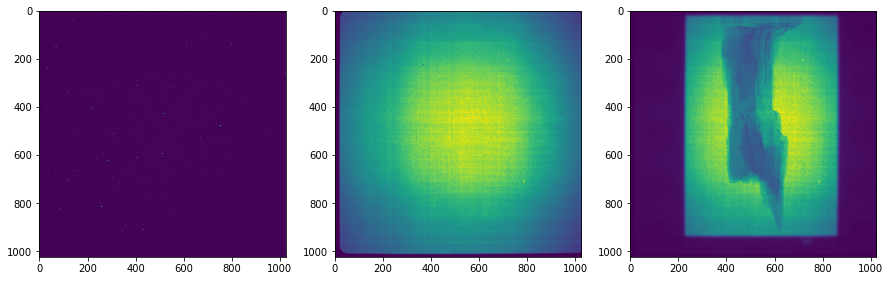

In [41]:
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(dc)
ax[1].imshow(ob)
ax[2].imshow(proj[0])


#### Preprocessing
Here the projections needs to be prepared for reconstruction. Typical operations are 
- Cropping
- Normalization (possibly with scattering correction)
- Spot cleaning
- Ring cleaning

In [42]:
nproj = amg.normalizeImage(img=proj, ob=ob, dc=dc, doseROI=[100,250,200,300])

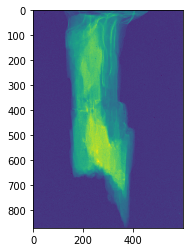

In [49]:
cproj = nproj[:,50:920,250:850]
plt.imshow(cproj[0])
del nproj

#### Prepare and run the back-projection

In [46]:
Nproj = cproj.shape[0]
# Information per projection
args = {"angles"  : np.linspace(0,360,num=Nproj), 
        "weights" : np.ones(Nproj)/Nproj}

# Geometry information
recon.configure({   "center" : 295, 
                    "resolution" : 0.05
                })

In [47]:
recon.process(cproj[:,500:532,:],args) # Reconstruct a part of the slices (32 slices here)

vol = recon.volume() # Retrieve the reconstructed volume

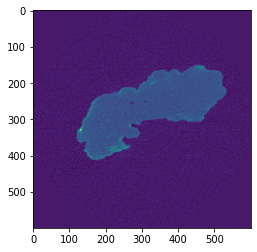

In [48]:
plt.imshow(vol[0])

In [50]:
import ipyvolume as ipv

In [54]:
ipv.quickvolshow(vol[0:31])

/Users/kaestner/opt/anaconda3/lib/python3.7/site-packages/ipyvolume/widgets.py:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
/Users/kaestner/opt/anaconda3/lib/python3.7/site-packages/ipyvolume/utils.py:204: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2])/2
/Users/kaestner/opt/anaconda3/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + 

In [52]:
vol.shape

(626, 600, 600)